In [1]:
import wradlib as wrl
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
warnings.filterwarnings('ignore')

from osgeo import osr

import pickle

import pyart

import numpy as np


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
from matplotlib.collections import PatchCollection
from matplotlib.colors import from_levels_and_colors
import matplotlib.patches as patches

In [3]:
import os

os.environ['LC_NUMERIC']='C'

Read the radar grid coordinates. These coordinates are in WGS84 CRS.

In [4]:
# Getting back the objects:
with open('radar_grid.pkl','rb') as f:  # Python 3: open(..., 'rb')
    x_rad, y_rad = pickle.load(f)

Read the watershed shapefile.

In [5]:
# this file is in UTM
fname_shp = r'C:/Users/iac6311/Documents/Work/Data/GIS/USA/CHI_shps/city_detailed_fixed_utm.shp'

In [6]:
dataset, inLayer = wrl.io.open_vector(fname_shp)
borders, keys = wrl.georef.get_vector_coordinates(inLayer, key='objectid')

Define different projections that will be used in the processing.

In [7]:
proj_wgs = osr.SpatialReference()
proj_wgs.ImportFromEPSG(4326)

proj_IL = osr.SpatialReference()
proj_IL.ImportFromEPSG(26771)

proj_IL_UTM = osr.SpatialReference()
proj_IL_UTM.ImportFromEPSG(26916)

0

Put the two coordinate grids in one array.

In [8]:
grid_xy = np.zeros((300,300,2))

grid_xy[:,:,0] = x_rad
grid_xy[:,:,1] = y_rad

Reproject the radar grid to UTM, to match the shapefile.

In [9]:
grid_xy_utm = wrl.georef.reproject(grid_xy,
                                projection_source=proj_wgs,
                                projection_target=proj_IL_UTM)

In [10]:
print(grid_xy_utm.shape)
print(grid_xy_utm[:5])

(300, 300, 2)
[[[ 284847.57546232 4485132.08909503]
  [ 285672.43041583 4485122.09771765]
  [ 286497.28178539 4485112.10541526]
  ...
  [ 529731.16477703 4482122.56077514]
  [ 530555.55719424 4482112.28006985]
  [ 531379.95009244 4482101.99834006]]

 [[ 284857.5242393  4485953.74522311]
  [ 285682.3801497  4485943.75093724]
  [ 286507.23247643 4485933.75573553]
  ...
  [ 529741.40993718 4482943.75539302]
  [ 530565.80339401 4482933.47449603]
  [ 531390.19733213 4482923.19258367]]

 [[ 284867.47523913 4486775.40233558]
  [ 285692.33210185 4486765.40514143]
  [ 286517.18538117 4486755.40704063]
  ...
  [ 529751.6559627  4483764.95106108]
  [ 530576.05045459 4483754.66997262]
  [ 531400.44542805 4483744.38787791]]

 [[ 284877.42846166 4487597.06043246]
  [ 285702.28627211 4487587.06033027]
  [ 286527.14049944 4487577.05933058]
  ...
  [ 529761.9028534  4484586.14777939]
  [ 530586.29837579 4484575.86649966]
  [ 531410.69438003 4484565.58422284]]

 [[ 284887.38390674 4488418.7195138 ]
  [ 

Create a mask to reduce size.

In [11]:
# Reduce grid size using a bounding box (to enhancing performance)
bbox = inLayer.GetExtent()

In [12]:
print(bbox) # in UTM

(441922.2425775856, 447483.21417111694, 4644247.145215561, 4647285.762941361)


In [13]:
buffer = 5000.
bbox = dict(left=bbox[0] - buffer, right=bbox[1] + buffer,
            bottom=bbox[2] - buffer, top=bbox[3] + buffer)
mask = (((grid_xy_utm[..., 1] > bbox['bottom']) & (grid_xy_utm[..., 1] < bbox['top'])) &
        ((grid_xy_utm[..., 0] > bbox['left']) & (grid_xy_utm[..., 0] < bbox['right'])))

Have a look at the mask.

(300, 300)


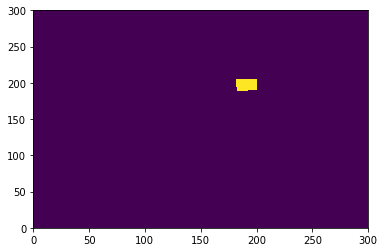

In [14]:
print(mask.shape)
plt.pcolormesh(mask)

In [17]:
# Create vertices for each grid cell
# (MUST BE DONE IN NATIVE COORDINATES)

grdverts = wrl.zonalstats.grid_centers_to_vertices(x_rad[mask],
                                                   y_rad[mask], 0.01,
                                                   0.01)

In [19]:
# And reproject to Cartesian reference system (here: UTM)
grdverts = wrl.georef.reproject(grdverts,
                                projection_source=proj_wgs,
                                projection_target=proj_IL_UTM)

In [20]:
grdverts.shape

(291, 5, 2)

In [21]:
grdverts

array([[[ 437279.61188044, 4638797.39268766],
        [ 438109.10909215, 4638790.13014848],
        [ 438118.7662081 , 4639900.41033497],
        [ 437289.39844326, 4639907.67315324],
        [ 437279.61188044, 4638797.39268766]],

       [[ 438104.2127755 , 4638786.9482837 ],
        [ 438933.71015684, 4638779.78187868],
        [ 438943.23858089, 4639890.06178584],
        [ 438113.87064567, 4639897.22846627],
        [ 438104.2127755 , 4638786.9482837 ]],

       [[ 438928.81263941, 4638776.50462962],
        [ 439758.31020417, 4638769.43435816],
        [ 439767.70993711, 4639879.7139895 ],
        [ 438938.34181771, 4639886.78453268],
        [ 438928.81263941, 4638776.50462962]],

       ...,

       [[ 449805.23743722, 4650962.72413827],
        [ 450633.30066995, 4650956.90921836],
        [ 450641.03342584, 4652067.20687047],
        [ 449813.09991088, 4652073.02200599],
        [ 449805.23743722, 4650962.72413827]],

       [[ 450629.82622448, 4650952.2750616 ],
        [ 451

Create instance of type ZonalDataPoly from source grid and catchment array. This needs to be done only once, then dump to file. The files that will be saved are the `src` shapefile (radar pixels), `trg` shapefile (original catchment), and `dst` shapefile (the radar pixels cut according to `trg`). 

In [22]:
%%time
# Create instance of type ZonalDataPoly from source grid and
# catchment array
zd = wrl.zonalstats.ZonalDataPoly(grdverts, borders)

Wall time: 254 ms


In [23]:
%%time
# dump to file
zd.dump_vector('zonal_poly_cart_1')

Wall time: 51.9 ms


In [24]:
%%time
# Create instance of type ZonalStatsPoint from zonal data object
obj3 = wrl.zonalstats.ZonalStatsPoly(zd)

Wall time: 446 ms


Read the gridded data.

In [25]:
data, attrs = wrl.io.from_hdf5('output/gridded_KLOT20130418_070000.hdf5')

# # Getting back the objects:
# with open('radarparams.pkl','rb') as f:  # Python 3: open(..., 'rb')
#     sitecoords, az, r = pickle.load(f)

Preview the gridded data.

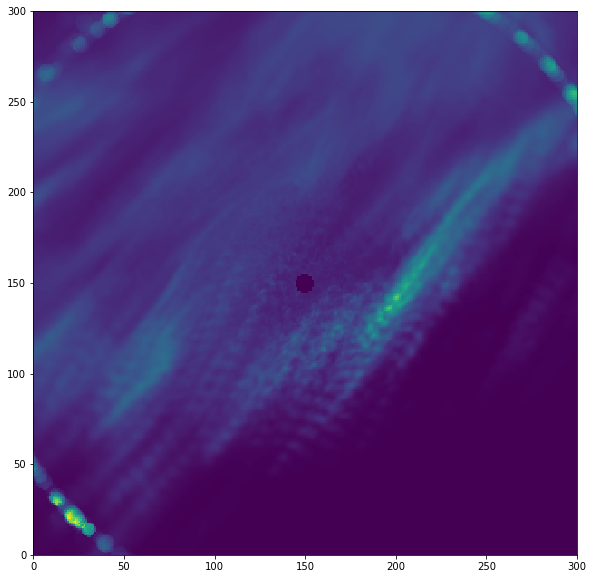

In [32]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, aspect='equal')
#wrl.vis.plot_ppi(data,r=r, az=az, site=sitecoords,proj=proj_wgs, vmin=0, vmax=20, cmap=pyart.graph.cm_colorblind.HomeyerRainbow,ax=ax)
#wrl.vis.add_lines(ax, borders, color='black', lw=2, zorder=4)
plt.pcolormesh(data)
#plt.xlim(-88,-87.5)
#plt.ylim(41.4,42.2)

Mask the data to reduce size. 

In [28]:
data_ = data[mask]

In [29]:
# Compute stats for target polygons
avg3 = obj3.mean(data_.ravel())

In [30]:
def testplot(cats, catsavg, xy, data,
             levels=[0, 1, 2, 3, 4, 5, 10, 15, 20, 25, 30, 40, 50, 100],
             title=""):
    """Quick test plot layout for this example file
    """
    colors = plt.cm.viridis(np.linspace(0, 1, len(levels)))
    mycmap, mynorm = from_levels_and_colors(levels, colors, extend="max")

    radolevels = [0, 1, 2, 3, 4, 5, 10, 15, 20, 25, 30, 40, 50, 100]
    radocolors = pyart.graph.cm_colorblind.HomeyerRainbow(np.linspace(0, 1, len(radolevels)))
    #pyart.graph.cm_colorblind()
    radocmap, radonorm = from_levels_and_colors(radolevels, radocolors,
                                                extend="max")

    fig = plt.figure(figsize=(10, 16))

    # Average rainfall sum
    ax = fig.add_subplot(211, aspect="equal")
    coll = PatchCollection(cats, array=catsavg, cmap=radocmap, norm=mynorm,
                           edgecolors='white', lw=0.5)
    ax.add_collection(coll)
    ax.autoscale()
    plt.colorbar(coll, ax=ax, shrink=0.5)
    plt.xlabel("NAD83 Z16 Easting")
    plt.ylabel("NAD83 Z16 Northing")
    plt.title(title)
    plt.draw()

    # Original radar data
    ax1 = fig.add_subplot(212, aspect="equal")
    pm = plt.pcolormesh(xy[:, :, 0], xy[:, :, 1], np.ma.masked_invalid(data),
                        cmap=radocmap, norm=radonorm)
    coll = PatchCollection(cats, facecolor='None', edgecolor='k', lw=0.5)
    ax1.add_collection(coll)
    cb = plt.colorbar(pm, ax=ax1, shrink=0.5)
    cb.set_label("(mm/h)")
    plt.xlabel("NAD83 Z16 Easting")
    plt.ylabel("NAD83 Z16 Northing")
    plt.title("Original radar rain sums")
    ax1.set_xlim(bbox['left']-10000,bbox['right']+10000)
    ax1.set_ylim(bbox['bottom']-10000,bbox['top']+10000)
    plt.draw()
    plt.tight_layout()

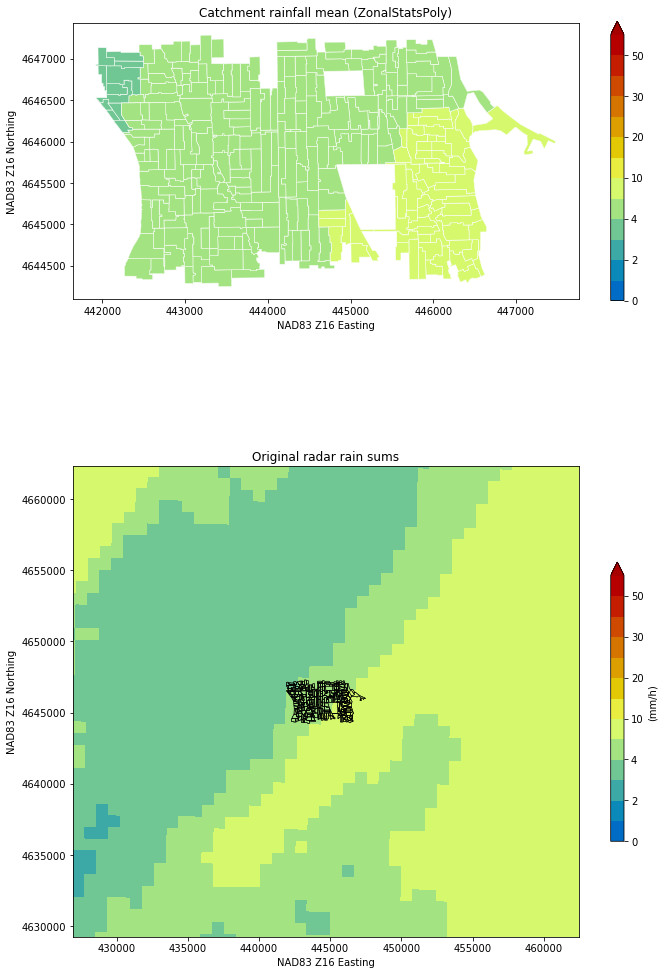

In [31]:
# PLOTTING Approach #2

# Target polygon patches
trg_patches = [patches.Polygon(item, True) for item in obj3.zdata.trg.data]

# Plot average rainfall and original data
testplot(trg_patches, avg3, grid_xy_utm, data,
         title="Catchment rainfall mean (ZonalStatsPoly)")